In [1]:
import numpy as np
import astropy.io.fits
from astropy.table import Table
import matplotlib.pyplot as plt
import scipy as sp 
import scipy.integrate as integrate
from scipy import log,exp,sqrt,stats
from astropy import units as u
import astropy.constants as const
from scipy.optimize import curve_fit
from scipy.integrate import quad
from astropy.stats import biweight_location, biweight_scale, bootstrap
from astropy.cosmology import LambdaCDM
from scipy.interpolate import interp1d
from astropy.coordinates import SkyCoord
import scipy.stats as stats
from astropy.stats import sigma_clip
from colossus.halo import profile_nfw
import sherpa.astro.ui as ui
cosmos = LambdaCDM(H0=67.77* u.km / u.Mpc / u.s, Om0=0.307115, Ode0=0.692885)  # define cosmology
c=const.c.to("km/s").value
%matplotlib inline

failed to import sherpa.image.ds9_backend due to 
'RuntimeErr: DS9Win unusable: Could not find ds9 on your PATH'


In [2]:
#path_2_data = 'massive_cluster0.fit'  # MACS J0717.5+3745  with 202 members 12 best bins
path_2_data = 'massive_cluster4.fit'   # id 33844 with 189 members 9 best bins
#path_2_data = 'massive_cluster2.fit'    # id 88034 with 199 members 9 best bins 
#path_2_data = 'massive_cluster1.fit'    # NA
#print('opening', path_2_data)
my_file=astropy.io.fits.open(path_2_data)
#print(my_file[1].data.columns)
data = my_file[1].data

In [3]:
data.field('mem_match_id')[0]

33844

In [4]:
ra=data.field('ra')
dec=data.field('dec')
zspec=data.field('zspec')

# Neglecting nans from the data set
z0=data.field('zspec')
mask0=np.where(z0>0)
z_gal=(zspec[mask0])
len(z_gal)

192

In [5]:
# After the removal of nans
ra_gal=ra[mask0]
dec_gal= dec[mask0]
len(z_gal),len(ra_gal),len(dec_gal)

(192, 192, 192)

(array([ 2.,  5., 18., 28., 63., 45., 16., 10.,  3.,  2.]),
 array([0.20871   , 0.21231   , 0.21591   , 0.21951   , 0.22311   ,
        0.22670999, 0.23031   , 0.23391   , 0.23751   , 0.24111   ,
        0.24471   ], dtype=float32),
 <BarContainer object of 10 artists>)

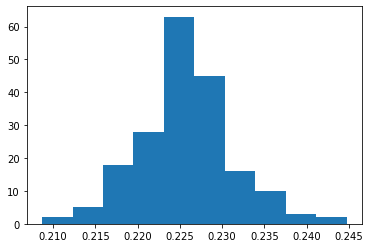

In [6]:
plt.hist(z_gal)

In [7]:
#from astropy.stats import jackknife_stats
#test_statistic = np.mean
#jackknife_stats(z_gal, test_statistic, 0.95)

In [8]:
#test_statistic = lambda x: (np.mean(x), np.var(x))
#estimate, bias, stderr, conf_interval = jackknife_stats(
#    z_gal, test_statistic, 0.95)
#estimate, bias, stderr, conf_interval

In [9]:
# Sigma clipping to remove the interlopers
clipped_redshift=sigma_clip(z_gal, sigma=3.0, maxiters=10000)

import numpy.ma as ma
zz=[]
zk=[]
for x in range(len(clipped_redshift)):
    if ma.is_masked(clipped_redshift[x])==False:
        zz.append(clipped_redshift[x])
        
    if not ma.is_masked(clipped_redshift[x])==False:
        zk.append(clipped_redshift[x])
        
    else:
        continue
len(zz)

189

In [10]:
z_halo=np.array(zz)
mask1=np.where(z_halo)
z_halo.max(),z_halo.min()

(0.23953, 0.2106206)

(array([ 2.,  5., 14., 23., 41., 43., 37.,  9., 10.,  5.]),
 array([0.2106206 , 0.21351154, 0.21640247, 0.21929342, 0.22218436,
        0.2250753 , 0.22796623, 0.23085718, 0.23374812, 0.23663905,
        0.23953   ], dtype=float32),
 <BarContainer object of 10 artists>)

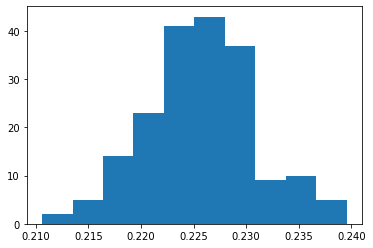

In [11]:
# Redshift distribution after Sigma cLipping
plt.hist(z_halo)

In [12]:
ra_masked=(ra_gal[mask1])
dec_masked=(dec_gal[mask1])
ra_cl= np.mean(ra_masked)
dec_cl= np.mean(dec_masked)

In [13]:
ra_cl,dec_cl

(250.0810551801969, 46.71371090280131)

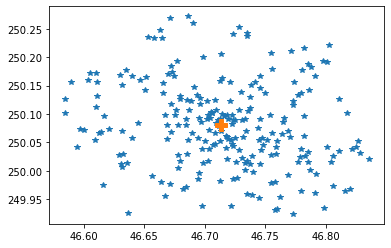

In [14]:
plt.plot(dec,ra,linestyle='none',marker='*')
plt.plot(dec_cl,ra_cl,linestyle='none',markersize=12,marker='P')

In [15]:
len(ra_masked),len(dec_masked)

(189, 189)

In [16]:
z_cl=np.mean(z_halo)
z_cl

0.22576718

In [17]:
# From astropy inbuilt module separation
coordinates_SubHaloes = SkyCoord( ra_masked , dec_masked , unit='deg', frame='icrs')
coordinate_cluster    = SkyCoord( ra_cl , dec_cl, unit='deg', frame='icrs') 
Angular_separation_Astropy = coordinates_SubHaloes.separation( coordinate_cluster )
Angular_separation_Astropy_radian = (Angular_separation_Astropy).to(u.radian)
Angular_separation_Astropy_radian.value

# Comoving distance
D = cosmos.comoving_distance(z_cl) 
print('the cluster at redshift ',z_cl,' is at dC=',D)
# Angular diameter distance
print('Angular diameter distance at the clusters redshift :' , cosmos.angular_diameter_distance(z_cl), 'per radian')
print('Angular diameter dist*u.degreeance at the clusters redshift :' , cosmos.angular_diameter_distance(z_cl)/(180/np.pi), 'per degree')
print('Angular diameter distance at the clusters redshift :' , (cosmos.angular_diameter_distance(z_cl)/(180/np.pi)).to(u.kpc)/60, 'per arc minute    ')

#
# The angular separation between sub haloes and the cluster converted in Mpc
r_proj = (Angular_separation_Astropy_radian * cosmos.angular_diameter_distance(z_cl)/u.radian).value  # where D is comoving distance
print('min, max projected distance : ',r_proj.min(), r_proj.max()) #'compared to the 3D virial radius', r_cl/1000)

the cluster at redshift  0.22576718  is at dC= 945.0400290820962 Mpc
Angular diameter distance at the clusters redshift : 770.9784078511607 Mpc per radian
Angular diameter dist*u.degreeance at the clusters redshift : 13.456111678786455 Mpc per degree
Angular diameter distance at the clusters redshift : 224.26852797977423 kpc per arc minute    
min, max projected distance :  0.03329280632598047 1.8051468305132619


(array([ 2.,  5., 14., 23., 41., 43., 37.,  9., 10.,  5.]),
 array([0.2106206 , 0.21351154, 0.21640247, 0.21929342, 0.22218436,
        0.2250753 , 0.22796623, 0.23085718, 0.23374812, 0.23663905,
        0.23953   ], dtype=float32),
 <BarContainer object of 10 artists>)

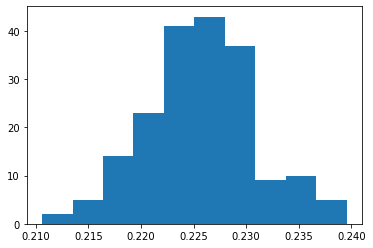

In [18]:
cosmos.comoving_distance(z_halo).value
plt.hist(z_halo)

In [19]:
#Computing the actual 3D distances between the galaxies and the cluster center
D_cl=cosmos.comoving_distance(z_halo).value
D_clus=cosmos.comoving_distance(z_cl).value
d_C = D_cl
dc_mpc = (d_C)
dc_interpolation = interp1d(z_halo, dc_mpc)
z_interpolation = interp1d(dc_mpc, z_halo)
def get_x_y_z(ra_radian, dec_radian, rr):
    phi   = ( ra_radian   - 180 ) * np.pi / 180.
    theta = (dec_radian + 90 ) * np.pi / 180.
    xx = rr * np.cos( phi) * np.sin( theta )
    yy = rr * np.sin( phi) * np.sin( theta )
    zz = rr * np.cos( theta )
    return xx, yy, zz

# Cartesian position of the galaxies
xx, yy, zz = get_x_y_z(ra_masked, dec_masked, dc_mpc)
    
# Cartesian position of the galaxies
xx_cl, yy_cl, zz_cl = get_x_y_z(ra_cl, dec_cl, D_clus)
    
# Getting the distances of the Galaxies with respect to the CLusters

distances = np.array(np.sqrt((xx_cl-xx)**2 + (yy_cl-yy)**2 + (zz_cl-zz)**2))
distances.max()

59.975647923017675

In [20]:
max(D_cl), D_clus, min(D_cl)

(999.1052316025974, 945.0400290820962, 885.0648566895778)

In [21]:
c1 = SkyCoord(ra_cl  *u.deg, dec_cl *u.deg, distance=D_cl*u.Mpc, frame='icrs')
c2 = SkyCoord(ra_masked*u.deg, dec_masked *u.deg, distance=D_clus*u.Mpc, frame='icrs')
sep = c1.separation_3d(c2)
sep.max()  

<Distance 59.97564792 Mpc>

In [22]:
z_cl

0.22576718

In [23]:
ra_cl,dec_cl

(250.0810551801969, 46.71371090280131)

In [24]:
N_subhaloes=len(r_proj)
def get_bins(r_proj, N_per_bin=15):
    dR=0.0001
    
    #choosing the bins
    r_bins_fine = np.arange(0., 2.5, dR)
    
    # Projected distance
    N_2D_fine, bins_2D_fine = np.histogram(np.array(r_proj), bins = r_bins_fine)
    R_2D_fine = (bins_2D_fine[1:] + bins_2D_fine[:-1])/2.

    #rint( np.cumsum( N_2D_fine) )
    itp_bins = interp1d(np.cumsum( N_2D_fine), R_2D_fine )
    
    #rint(itp_bins(np.arange(N_per_bin, N_subhaloes, N_per_bin)))
    bins_2D = np.hstack((0., itp_bins(np.arange(N_per_bin, N_subhaloes, N_per_bin)), 2.5 ))
    #rint(bins_2D)
    
    return bins_2D
    # Three D distance
    #N_3D, bins_3D = np.histogram(np.array(distances[mask]), bins = r_bins)

In [25]:
def Burkert_nu(r):
    """
    Burkert profile
    """
    rs = 0.7  # r200 / c200
    rhos=120.0
    return rhos/(1+(r/rs)*(1+(r/rs)**3))

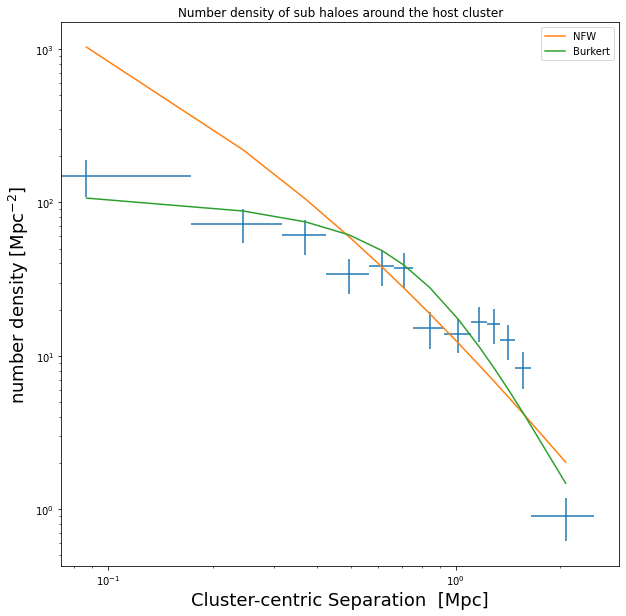

In [26]:
bins_2D = get_bins(r_proj, N_per_bin=15)
# Projected distance
N_2D, bins_2D = np.histogram(np.array(r_proj), bins = bins_2D)

#Getting the number density profile in 2D 
R_2D = (bins_2D[1:] + bins_2D[:-1])/2.
n_2D = N_2D /(np.pi*( ( bins_2D[1:]**2 - bins_2D[:-1]**2) ) )
dR_2D = [ bins_2D[1:] - R_2D, R_2D - bins_2D[:-1] ]
# central point of each separation 

from colossus.halo import profile_nfw
rhos = 270.0
rs = 0.465
prof = profile_nfw.NFWProfile(rhos = rhos, rs = rs)

# taking a dataset to model 
rho_data = prof.density(R_2D)

plt.figure(0, (10, 10))

#plt.plot(R_2D, n_2D, color='black', linestyle='dashed', linewidth = 2, marker='o', markerfacecolor='green', markersize=12)
plt.errorbar(R_2D, n_2D, yerr=n_2D*N_2D**-0.5, xerr=dR_2D, ls='')
plt.plot(R_2D, 1*rho_data , label = 'NFW');
plt.plot(R_2D,Burkert_nu(R_2D) ,'-', label = 'Burkert');


plt.yscale('log')
plt.xscale('log')
plt.title('Number density of sub haloes around the host cluster')
plt.xlabel('Cluster-centric Separation  [Mpc]',fontsize=18)
plt.ylabel(r'number density [Mpc$^{-2}$]',fontsize=18) 
#plt.axvline(x=r_cl/1000.,linestyle='dashed',label = 'Rvir')
plt.legend(loc=1, numpoints=1)
plt.show()

In [27]:
1*rho_data

array([1029.89154861,  219.65459171,  105.33939876,   59.8142636 ,
         37.82452253,   27.64685708,   18.84817555,   12.09990027,
          8.6769259 ,    6.84427289,    5.44498683,    4.20389659,
          2.02599087])

In [28]:
def poiss_err(n, alpha=0.32):
    """
    Poisson error (variance) for n counts.
    An excellent review of the relevant statistics can be found in 
    the PDF statistics review: http://pdg.lbl.gov/2018/reviews/rpp2018-rev-statistics.pdf,
    specifically section 39.4.2.3
    :param: alpha corresponds to central confidence level 1-alpha, 
            i.e. alpha = 0.32 corresponds to 68% confidence
    """
    sigma_lo = sp.stats.chi2.ppf(alpha/2,2*n)/2
    sigma_up = sp.stats.chi2.ppf(1-alpha/2,2*(n+1))/2
    return sigma_lo, sigma_up

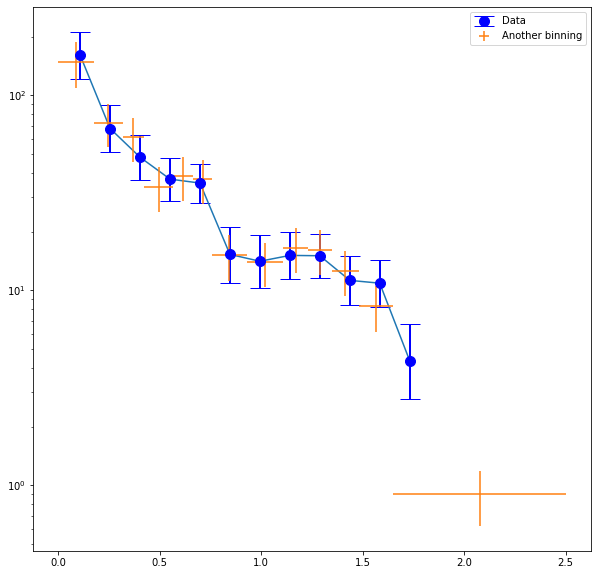

In [29]:
nbins=12
n_data,R_bins=np.histogram(r_proj, nbins, range=(r_proj.min(), r_proj.max()))
# ignore bin with zero count
select = n_data > 0 
n_data = n_data[select]
R_bins_low = R_bins[:-1][select]
R_bins_high = R_bins[1:][select]

# compute poisson error  errors in n_data
n_data_low, n_data_high = poiss_err(n_data, alpha=0.32)
R_bins_ce = 0.5 * (R_bins_low + R_bins_high)

# light profile
delta_R2 = (R_bins_high**2 - R_bins_low**2)
Sig_data = n_data / (np.pi * delta_R2)
Sig_data_low = n_data_low / (np.pi * delta_R2)
Sig_data_high = n_data_high / (np.pi * delta_R2)

# error
sig_low = Sig_data - Sig_data_low
sig_high = Sig_data_high - Sig_data

# plotting
plt.figure(0, (10, 10))
plt.errorbar(
    (R_bins_ce), Sig_data, 
    yerr=(Sig_data - Sig_data_low, Sig_data_high - Sig_data), 
    color='blue', lw=2, ms=20, fmt='.', capsize=10, label='Data')
plt.plot(R_bins_ce,Sig_data,'o',linestyle='-')
plt.errorbar(R_2D, n_2D, yerr=n_2D*N_2D**-0.5, xerr=dR_2D, ls='',label='Another binning')
plt.yscale('log')
#plt.xscale('log')
plt.legend()

plt.show()

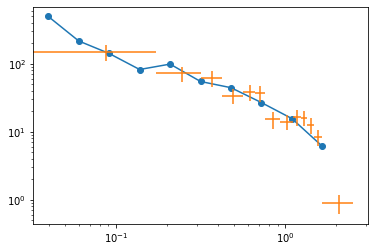

In [30]:
logR=np.log10(r_proj)
N_star = len(r_proj)
    
# binning
nbins = 10
logR_min = np.floor(np.min(logR)*10) / 10
logR_max = np.ceil(np.max(logR)*10) / 10
n_data, logR_bins = np.histogram(logR, nbins, range=(logR_min, logR_max))
n_data,logR_bins

# ignore bin with zero count
select = n_data > 0 
n_data = n_data[select]
logR_bins_lo = logR_bins[:-1][select]
logR_bins_hi = logR_bins[1:][select]

    # compute poisson error 
n_data_lo, n_data_hi = poiss_err(n_data, alpha=0.32)
    
n_data, n_data_lo, n_data_hi, logR_bins_lo, logR_bins_hi

#
R_bins_lo = 10**logR_bins_lo
R_bins_hi = 10**logR_bins_hi
R_bins_ce = 0.5 * (R_bins_lo + R_bins_hi)

    # light profile
delta_R2 = (R_bins_hi**2 - R_bins_lo**2)
Sig_data = n_data / (np.pi * delta_R2)
Sig_data_lo = n_data_lo / (np.pi * delta_R2)
Sig_data_hi = n_data_hi / (np.pi * delta_R2)
    
Sig_data, Sig_data_lo, Sig_data_hi, R_bins_ce
plt.plot(R_bins_ce,Sig_data,'o',linestyle='-')
plt.errorbar(R_2D, n_2D, yerr=n_2D*N_2D**-0.5, xerr=dR_2D, ls='')
#t.plot(calc_Sigma(r_proj)[3],calc_Sigma(r_proj)[0],'+',linestyle='-')

plt.yscale('log')
plt.xscale('log')

In [31]:
def poiss_err(n, alpha=0.32):
    """
    Poisson error (variance) for n counts.
    An excellent review of the relevant statistics can be found in 
    the PDF statistics review: http://pdg.lbl.gov/2018/reviews/rpp2018-rev-statistics.pdf,
    specifically section 39.4.2.3
    :param: alpha corresponds to central confidence level 1-alpha, 
            i.e. alpha = 0.32 corresponds to 68% confidence
    """
    sigma_lo = sp.stats.chi2.ppf(alpha/2,2*n)/2
    sigma_up = sp.stats.chi2.ppf(1-alpha/2,2*(n+1))/2
    return sigma_lo, sigma_up

def calc_nstar(R):
    ''' Calculate the projected number of stars as a function of projected radius R'''
    # calculate the projected radius
    logR = np.log10(R)
    N_star = len(R)
    
    # binning
    nbins = int(np.ceil(np.sqrt(N_star))) 
    logR_min = np.floor(np.min(logR)*10) / 10
    logR_max = np.ceil(np.max(logR)*10) / 10
    n_data, logR_bins = np.histogram(logR, nbins, range=(logR_min, logR_max))
    
    # ignore bin with zero count
    select = n_data > 0 
    n_data = n_data[select]
    logR_bins_lo = logR_bins[:-1][select]
    logR_bins_hi = logR_bins[1:][select]

    # compute poisson error 
    n_data_lo, n_data_hi = poiss_err(n_data, alpha=0.32)
    calc_Sigma
    return n_data, n_data_lo, n_data_hi, logR_bins_lo, logR_bins_hi

def calc_Sigma(R):
    ''' Calculate the projected 2d light profile Sigma(R) where R is the projected radius '''
    n_data, n_data_lo, n_data_hi, logR_bins_lo, logR_bins_hi =  calc_nstar(R)
    R_bins_lo = 10**logR_bins_lo
    R_bins_hi = 10**logR_bins_hi
    R_bins_ce = 0.5 * (R_bins_lo + R_bins_hi)

    # light profile
    delta_R2 = (R_bins_hi**2 - R_bins_lo**2)
    Sig_data = n_data / (np.pi * delta_R2)
    Sig_data_lo = n_data_lo / (np.pi * delta_R2)
    Sig_data_hi = n_data_hi / (np.pi * delta_R2)
    
    return Sig_data, Sig_data_lo, Sig_data_hi, R_bins_ce

In [32]:
calc_Sigma(r_proj)[3]

array([0.03707032, 0.04984226, 0.06701456, 0.09010328, 0.12114683,
       0.16288589, 0.21900544, 0.29446002, 0.39591118, 0.5323156 ,
       0.71571582, 0.96230346, 1.29384865, 1.73962205])

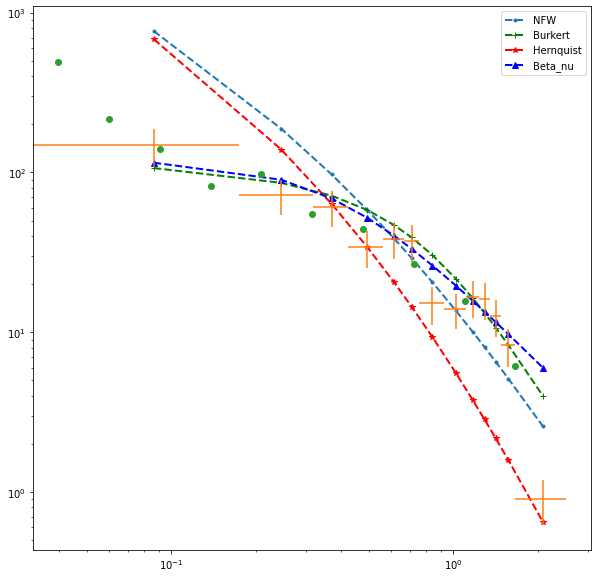

In [33]:
# Density profile models
from colossus.halo import profile_nfw
#cosmology.setCosmology('planck18')
rs = 0.7
rhos = 120.0
prof = profile_nfw.NFWProfile(rhos = rhos, rs = rs)
rho_nfw = prof.density(R_2D)

# Burkert profile   @Biviano & Katgert 2004
def Burkert_nu(r):
    """
    Burkert profile
    """
    rs = 0.7  # r200 / c200
    rhos=120.0
    return rhos/(1+(r/rs)*(1+(r/rs)**2))

# NFW density profile
def Hernquist_nu(r):
    """
    Hernquist density profile
    """    
    rs = 0.7  # r200 / c200
    rhos=120.0
    return rhos / ((r / rs )* (1 + (r / rs) ) **3 )


# Beta /SIS alternative model, if NFW doesn't works 
def Beta_nu(r):
    rs = 0.4 # r200 / c200
    rhos=120.0   # 
    beta= 0.9     
    return rhos / ((1.0 + (r/rs)** 2))**beta
 


plt.figure(0, (10, 10))
plt.plot(R_2D, rho_nfw ,linestyle='dashed', linewidth = 2, marker='.', label = 'NFW');
plt.plot(R_2D,Burkert_nu(R_2D),'+',color='green',label='Burkert',linestyle='dashed', linewidth = 2)
plt.plot(R_2D,Hernquist_nu(R_2D),'*',color='red',label='Hernquist',linestyle='dashed', linewidth = 2)
plt.plot(R_2D,Beta_nu(R_2D) ,'^',color='blue',label='Beta_nu',linestyle='dashed', linewidth = 2)
plt.errorbar(R_2D, n_2D, yerr=n_2D*N_2D**-0.5, xerr=dR_2D, ls='')
plt.plot(R_bins_ce,Sig_data,'o')


plt.yscale('log')
plt.xscale('log')

plt.legend();

-------------------------------------------------------------------------------------
Profile fit: Varying 2 / 2 parameters.
Found analytical derivative function for quantity rho.
Found solution in 11 steps. Best-fit parameters:
Parameter       rhos = 1.66e+01 [7.67e+00 .. 3.58e+01]
Parameter         rs = 1.40e+00 [8.94e-01 .. 2.21e+00]
chi2 / Ndof = 57.9 / 11 = 5.26
-------------------------------------------------------------------------------------


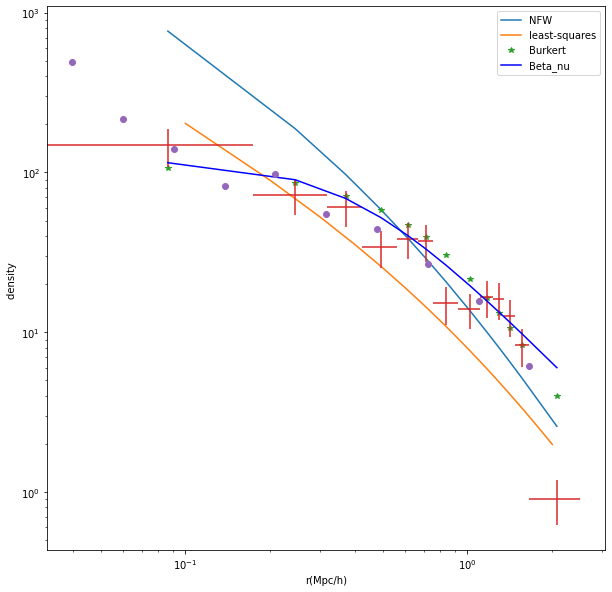

In [34]:
prof = profile_nfw.NFWProfile(rhos = rhos, rs = rs)
rho_nfw = prof.density(R_2D)

rr= np.arange(0,max(R_2D),0.1)

# Move the profile parameters away from the initial values
prof.setParameterArray([prof.par['rhos'] * 0.4, prof.par['rs'] * 3.0])

# Fit to the fake data using least-squares, compute the fitted profile
prof.fit(R_2D, n_2D, 'rho', q_err = n_2D*N_2D**-0.5, method = 'leastsq')
rho_fit_leastsq = prof.density(rr)

# Fit to the fake data using least-squares, compute the fitted profile
#prof.fit(R_2D, n_2D, 'rho', q_err = n_2D*N_2D**-0.5, method = 'mcmc', convergence_step = 500)
#rho_fit_mcmc = prof.density(rr)

plt.figure(0, (10, 10))
plt.xlabel('r(Mpc/h)')
plt.ylabel('density ')

plt.plot(R_2D, rho_nfw , '-', label = 'NFW');
plt.plot(rr, rho_fit_leastsq, '-', label = 'least-squares')
#plt.plot(rr, rho_fit_mcmc, '--', label = 'rho_fit_mcmc')
#lt.plot(R_2D,rho,'+',color='#d62728',)
plt.plot(R_2D,Burkert_nu(R_2D),'*',label = 'Burkert')
plt.errorbar(R_2D, n_2D, yerr=n_2D*N_2D**-0.5, xerr=dR_2D, ls='')
plt.plot(R_2D,Beta_nu(R_2D),'-',color='blue',label='Beta_nu')
plt.plot(R_bins_ce,Sig_data,'o')

plt.yscale('log')
plt.xscale('log')

plt.legend();


Dataset               = 1
Method                = neldermead
Statistic             = chi2
Initial fit statistic = 185.812
Final fit statistic   = 42.2039 at function evaluation 239
Data points           = 13
Degrees of freedom    = 11
Probability [Q-value] = 1.49321e-05
Reduced statistic     = 3.83672
Change in statistic   = 143.608
   Burkertmodel.rhos   304.271     
   Burkertmodel.rs   0.461685    


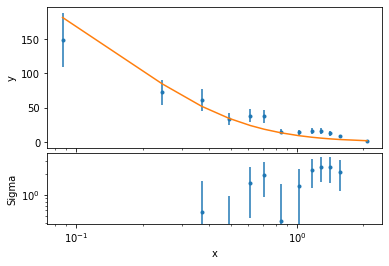

In [35]:
# Using Burkert profile
def Burkert(pars, r):
    """pars are [rhos, rs]"""
    rho = pars[0]/((1.0+r/pars[1])*(1.0+r/pars[1])**2)
    return rho

ui.load_user_model(Burkert,'Burkertmodel')

ui.add_user_pars('Burkertmodel',['rhos','rs'],[1,1])

ui.load_arrays(1,R_2D,n_2D,n_2D*N_2D**-0.5)

ui.set_model(1,Burkertmodel)

ui.set_stat('chi2')
ui.set_conf_opt('sigma',1)
ui.set_conf_opt('fast',False)
ui.set_method('simplex')
ui.set_conf_opt('max_rstat', 10)

ui.fit()
ui.plot_fit_delchi()
plt.xscale('log')
plt.yscale('log')

Dataset               = 1
Method                = neldermead
Statistic             = chi2
Initial fit statistic = 182.388
Final fit statistic   = 22.1484 at function evaluation 479
Data points           = 13
Degrees of freedom    = 10
Probability [Q-value] = 0.0143661
Reduced statistic     = 2.21484
Change in statistic   = 160.24
   Betamodel.rhos   137.507     
   Betamodel.rs   3.51242e+07 
   Betamodel.beta   3.94383e+07 


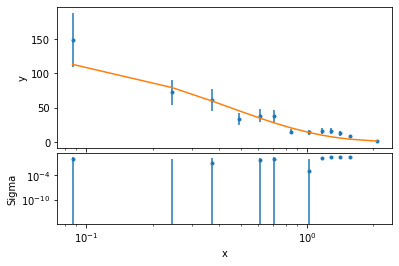

In [36]:
# Using Beta Model
def Beta_nu(pars, r):
    """pars are [rhos, rs, beta]"""
    rho = pars[0]/((1.0+r/pars[1])**2)**pars[2]
    return rho

ui.load_user_model(Beta_nu,'Betamodel')

ui.add_user_pars('Betamodel',['rhos','rs','beta'],[1,1,1])

ui.load_arrays(1,R_2D,n_2D,n_2D*N_2D**-0.5)

ui.set_model(1,Betamodel)

ui.set_stat('chi2')
ui.set_conf_opt('sigma',1)
ui.set_conf_opt('fast',False)
ui.set_method('simplex')
ui.set_conf_opt('max_rstat', 10)

ui.fit()
ui.plot_fit_delchi()
plt.xscale('log')
plt.yscale('log')

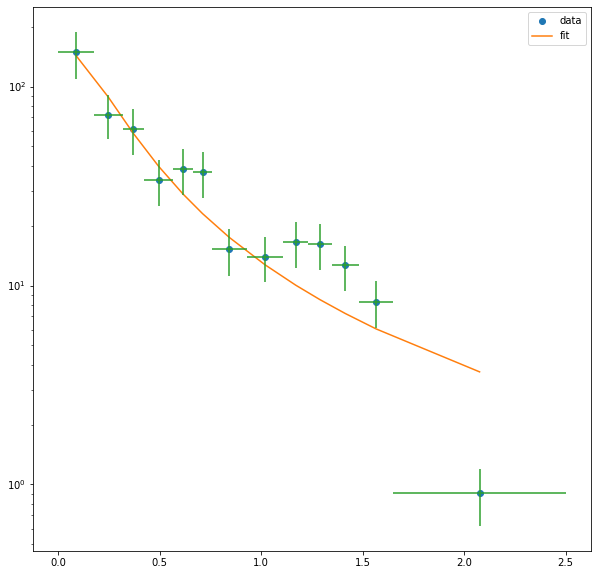

In [37]:
# Beta /SIS alternative model, if NFW doesn't works 
def Beta_nu(r,rhos,rs):
    return rhos / (1.0 + (r/rs)** 2)**0.9
popt, pcov = curve_fit(Beta_nu,R_2D,n_2D)
 
#Curve fit
parameters, covariance = curve_fit(Beta_nu,R_2D, n_2D)
fit_A=parameters[0]
fit_B=parameters[1]
#fit_c=parameters[2]
#plot
fit_y = Beta_nu(R_2D, fit_A, fit_B)
plt.figure(0, (10, 10))
plt.plot(R_2D, n_2D, 'o', label='data')
plt.plot(R_2D, fit_y, '-', label='fit')
plt.errorbar(R_2D, n_2D, yerr=n_2D*N_2D**-0.5, xerr=dR_2D, ls='')

plt.yscale('log')
#plt.xscale('log')
plt.legend()

In [38]:
# Assummed distance
r=np.linspace(0.03,2.0,len(r_proj))

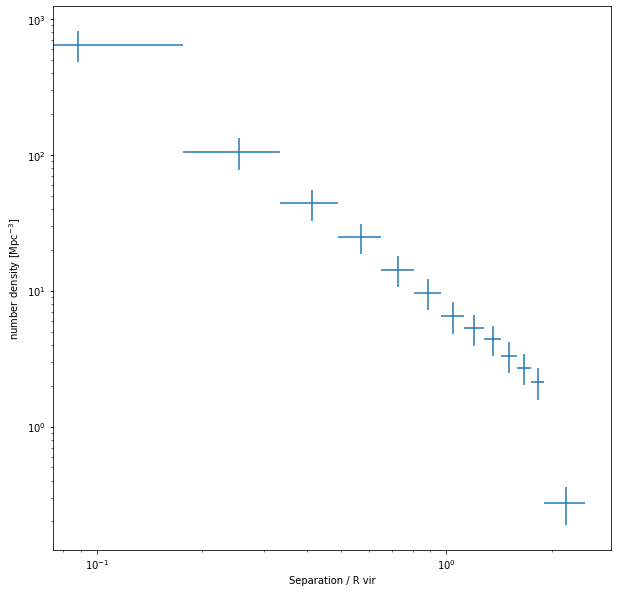

In [39]:
# Three D distance
bins_3D = get_bins(r, N_per_bin=15)
N_3D, bins_3D = np.histogram(r, bins = bins_3D)

R_3D = (bins_3D[1:] + bins_3D[:-1])/2.
dR_3D = [ bins_3D[1:] - R_3D, R_3D - bins_3D[:-1] ]

#Ns,rs=np.histogram(r)
number_density = N_3D/(np.pi*( 4* ( bins_3D[1:]**3-bins_3D[:-1]**3) / 3))

r_act = (bins_3D[1:] + bins_3D[:-1])/2.
#plt.xscale('log')
#plt.yscale('log')
plt.figure(0, (10, 10))

plt.errorbar(r_act, number_density, xerr=dR_3D, ls='', yerr=number_density * N_3D**-0.5, label='direct estimate')
#plt.plot(r_act, number_density, color='black', linestyle='dashed', linewidth = 2, marker='o', markerfacecolor='green', markersize=12)
plt.xlabel('Separation / R vir')
plt.ylabel(r'number density [Mpc$^{-3}$]')
plt.yscale('log')
plt.xscale('log')
plt.show()

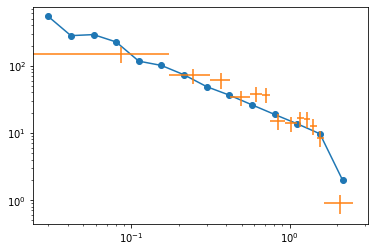

In [40]:
logR=np.log10(r)
N_star = len(r)
    
# binning
nbins = int(np.ceil(np.sqrt(N_star))) 
logR_min = np.floor(np.min(logR)*10) / 10
logR_max = np.ceil(np.max(logR)*10) / 10
n_data, logR_bins = np.histogram(logR, nbins, range=(logR_min, logR_max))
n_data,logR_bins

# ignore bin with zero count
select = n_data > 0 
n_data = n_data[select]
logR_bins_lo = logR_bins[:-1][select]
logR_bins_hi = logR_bins[1:][select]

    # compute poisson error 
n_data_lo, n_data_hi = poiss_err(n_data, alpha=0.32)
    
n_data, n_data_lo, n_data_hi, logR_bins_lo, logR_bins_hi

#
R_bins_lo = 10**logR_bins_lo
R_bins_hi = 10**logR_bins_hi
R_bins_ce = 0.5 * (R_bins_lo + R_bins_hi)

    # light profile
delta_R2 = (R_bins_hi**2 - R_bins_lo**2)
Sig_data = n_data / (np.pi * delta_R2)
Sig_data_lo = n_data_lo / (np.pi * delta_R2)
Sig_data_hi = n_data_hi / (np.pi * delta_R2)
    
Sig_data, Sig_data_lo, Sig_data_hi, R_bins_ce
plt.plot(R_bins_ce,Sig_data,'o',linestyle='-')
plt.errorbar(R_2D, n_2D, yerr=n_2D*N_2D**-0.5, xerr=dR_2D, ls='')

plt.yscale('log')
plt.xscale('log')

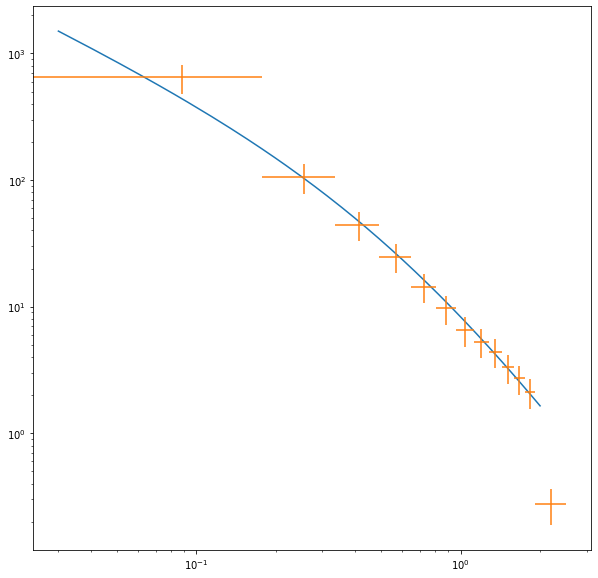

In [41]:
#  Modelling the nfw profile to the projected number density

from colossus.halo import profile_nfw
# Parameters
Rs=0.7
rhos =70.0
# Nfw as function of actual radius of the cluster
p_nfw = profile_nfw.NFWProfile(rhos = rhos, rs = rs)

rho_nfwr = p_nfw.density(r)
# Plotting the function 
plt.figure(0, (10, 10))

# Modelling with NFW
plt.plot(r,rho_nfwr , label = 'NFW');
plt.errorbar(r_act, number_density, xerr=dR_3D, ls='', yerr=number_density * N_3D**-0.5, label='direct estimate')
plt.yscale('log')
plt.xscale('log')


-------------------------------------------------------------------------------------
Profile fit: Varying 2 / 2 parameters.
Found analytical derivative function for quantity rho.
Found solution in 10 steps. Best-fit parameters:
Parameter       rhos = 4.63e+02 [2.02e+02 .. 1.06e+03]
Parameter         rs = 2.58e-01 [1.84e-01 .. 3.62e-01]
chi2 / Ndof = 36.2 / 11 = 3.29
-------------------------------------------------------------------------------------


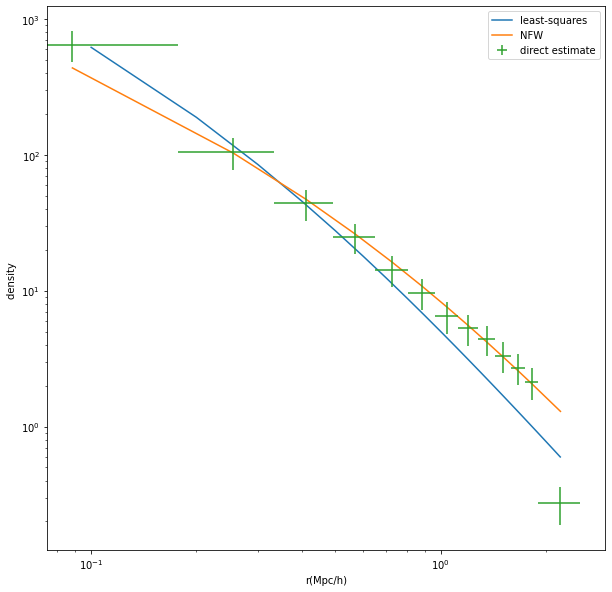

In [42]:
Rs=0.7
rhos =70.0
prof = profile_nfw.NFWProfile(rhos = rhos, rs = rs)

# taking a dataset to model 

rho_data = prof.density(R_3D)
rr= np.arange(0,max(R_3D),0.1)

# Move the profile parameters away from the initial values
prof.setParameterArray([prof.par['rhos'] * 0.4, prof.par['rs'] * 3.0])

# Fit to the fake data using least-squares, compute the fitted profile
prof.fit(R_3D, number_density, 'rho', q_err = number_density*N_3D**-0.5, method = 'leastsq')
rho_fit_leastsq = prof.density(rr)

# Fit to the fake data using least-squares, compute the fitted profile
#prof.fit(R_2D, n_2D, 'rho', q_err = n_2D*N_2D**-0.5, method = 'mcmc', convergence_step = 500)
#rho_fit_mcmc = prof.density(rr)

plt.figure(0, (10, 10))
plt.xlabel('r(Mpc/h)')
plt.ylabel('density ')

#lt.plot(R_2D, rho_nfw , '-', label = 'NFW');
plt.plot(rr, rho_fit_leastsq, '-', label = 'least-squares')

# Modelling with NFW
plt.plot(R_3D,rho_data , label = 'NFW');
#plt.plot(R_3D,Burkert_nu(R_3D) , label = 'Burkert');
plt.errorbar(R_3D, number_density, xerr=dR_3D, ls='', yerr=number_density * N_3D**-0.5, label='direct estimate')

# r200
#plt.axvline(x=r_cl/1000,linestyle='dashed',label = 'R200')
plt.yscale('log')
plt.xscale('log')
plt.legend(loc=1, numpoints=1)

Datasets              = 1, 2
Method                = neldermead
Statistic             = chi2
Initial fit statistic = 204.149
Final fit statistic   = 56.8588 at function evaluation 631
Data points           = 26
Degrees of freedom    = 21
Probability [Q-value] = 3.77049e-05
Reduced statistic     = 2.70756
Change in statistic   = 147.29
   Betamodel.rhos   137.467     
   Betamodel.rs   3.51284e+07 
   Betamodel.beta   3.94366e+07 
   Burkertmodel.rhos   3048.63     
   Burkertmodel.rs   0.134883    


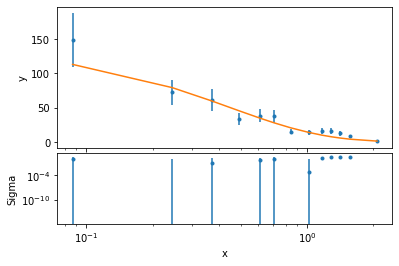

In [43]:
# Using Burkert profile
def Burkert(pars, r):
    """pars are [rhos, rs]"""
    rho = pars[0]/((1.0+r/pars[1])*(1.0+r/pars[1])**2)
    return rho

ui.load_user_model(Burkert,'Burkertmodel')

ui.add_user_pars('Burkertmodel',['rhos','rs'],[1,1])

ui.load_arrays(2,R_3D,number_density,number_density*N_3D**-0.5)

ui.set_model(2,Burkertmodel)

ui.set_stat('chi2')
ui.set_conf_opt('sigma',2)
ui.set_conf_opt('fast',False)
ui.set_method('simplex')
ui.set_conf_opt('max_rstat', 10)

ui.fit()
ui.plot_fit_delchi()
plt.xscale('log')
plt.yscale('log')

Datasets              = 1, 2
Method                = neldermead
Statistic             = chi2
Initial fit statistic = 194.73
Final fit statistic   = 47.8313 at function evaluation 948
Data points           = 26
Degrees of freedom    = 20
Probability [Q-value] = 0.000449203
Reduced statistic     = 2.39156
Change in statistic   = 146.899
   Betamodel.rhos   137.458     
   Betamodel.rs   3.51283e+07 
   Betamodel.beta   3.94364e+07 
   Betamodel.rhos   230.928     
   Betamodel.rs   2.42901     
   Betamodel.beta   4.90133     


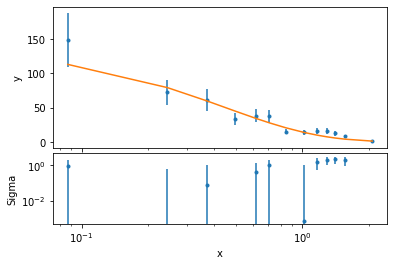

In [44]:
#Using Beta Model
def Beta_nu(pars, r):
    """pars are [rhos, rs, beta]"""
    rho = pars[0]/((1.0+r/pars[1])**2)**pars[2]
    return rho

ui.load_user_model(Beta_nu,'Betamodel')

ui.add_user_pars('Betamodel',['rhos','rs','beta'],[1,1,1])

ui.load_arrays(2,R_3D,number_density,number_density*N_3D**-0.5)

ui.set_model(2,Betamodel)

ui.set_stat('chi2')
ui.set_conf_opt('sigma',2)
ui.set_conf_opt('fast',False)
ui.set_method('simplex')
ui.set_conf_opt('max_rstat', 10)

ui.fit()
ui.plot_fit_delchi()
plt.xscale('log')
plt.yscale('log')

In [45]:
"""
The interplation of dndR for solving the integral first of all 
Stacking the Proj and dndR

""" 
#Getting the derivative term of n wrt R_proj  ie dndR
dndR = np.array(np.gradient(n_2D,R_2D))
n_2D_no0 = N_2D
n_2D_no0[N_2D==0] = 1

dndR_up = np.array(np.gradient( n_2D + n_2D * n_2D_no0**-0.5, R_2D ))
dndR_low = np.array(np.gradient( n_2D - n_2D * n_2D_no0**-0.5, R_2D ))

def get_nu_all(dndR):
    xx = np.hstack((np.array([0]),np.array(R_2D), np.array([10.]) ))
    yy = np.hstack((np.array(dndR[0]),np.array(dndR), np.array([0.]) ))

    # getting the interpolation
    inter1 = interp1d(xx, yy, bounds_error=True)

    # De-projection of the number density profile from 
    # 2D to 3D using the Abel inversion equation

    def nu(R, r):
        """
        Latex equation
        Reference to the article it comes from
        """
        return (-1/np.pi)*(inter1(R)/((R**2 - r**2)**0.5))
        #return (-1/(2*np.pi**2))*(inter1(R)/((R**2 - r**2)**0.5))

    
    nu_all=[integrate.quad(nu, r_i, 2.0, args=(r_i))[0] for r_i in R_3D]
    return nu_all

nu_all = get_nu_all(dndR)
nu_all_up = get_nu_all(dndR_up)
nu_all_low = get_nu_all(dndR_low)

/tmp/ipykernel_6352/3378018301.py:33: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  nu_all=[integrate.quad(nu, r_i, 2.0, args=(r_i))[0] for r_i in R_3D]
/tmp/ipykernel_6352/3378018301.py:33: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  nu_all=[integrate.quad(nu, r_i, 2.0, args=(r_i))[0] for r_i in R_3D]


In [46]:
nu_all

[276.43662168938897,
 94.9275278489364,
 41.907664020320496,
 18.905528293720458,
 23.762195991360706,
 11.843317434215662,
 3.589088711564647,
 5.696016020454939,
 7.10581617100805,
 5.712392939599861,
 4.077748934710685,
 2.542192699908483,
 nan]

Datasets              = 1, 2
Method                = neldermead
Statistic             = chi2
Initial fit statistic = nan
Final fit statistic   = nan at function evaluation 5111
Data points           = 26
Degrees of freedom    = 21
Probability [Q-value] = nan
Reduced statistic     = nan
Change in statistic   = nan
   Betamodel.rhos   137.458     
   Betamodel.rs   3.51283e+07 
   Betamodel.beta   3.94364e+07 
   nfwmodel.rhos   1           
   nfwmodel.rs    1           


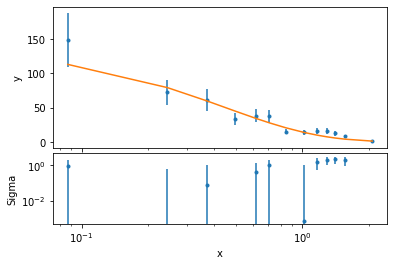

In [47]:
import sherpa.astro.ui as ui

def nfw1(pars, r):
    """pars are [rhos, rs]"""
    rho = pars[0]/((r/pars[1])*(1+r/pars[1])**2)
    return rho



ui.load_user_model(nfw1,'nfwmodel')

ui.add_user_pars('nfwmodel',['rhos','rs'],[1,1])

ui.load_arrays(2,R_3D,nu_all,nu_all*N_3D**-0.5)

ui.set_model(2,nfwmodel)

ui.set_stat('chi2')
ui.set_conf_opt('sigma',1)
ui.set_conf_opt('fast',False)
ui.set_method('simplex')
ui.set_conf_opt('max_rstat', 10)

ui.fit()
ui.plot_fit_delchi()
plt.xscale('log')
plt.yscale('log')

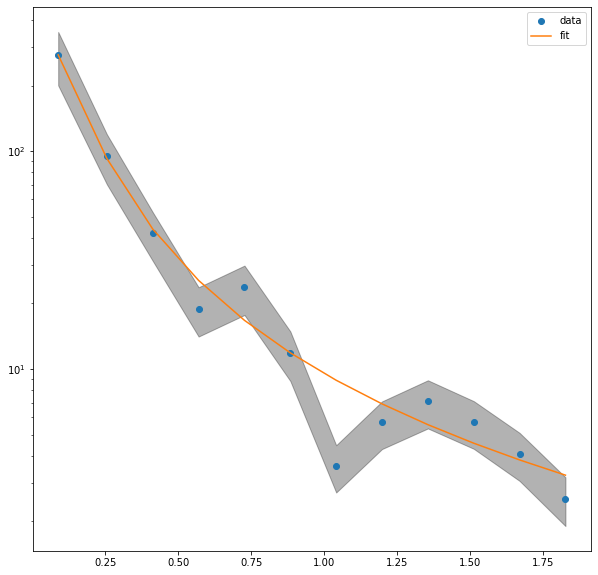

In [48]:
# Beta /SIS alternative model, if NFW doesn't works 
def Beta_nu(r,rhos,rs):
    return rhos / (1.0 + (r/rs)** 2)**0.9
#popt, pcov = curve_fit(Beta_nu,R_2D,n_2D)

#Curve fit
parameters, covariance = curve_fit(Beta_nu,R_3D[:-1], nu_all[:-1])
fit_A=parameters[0]
fit_B=parameters[1]
#fit_c=parameters[2]
#plot
fit_y = Beta_nu(R_3D[:-1], fit_A, fit_B)
plt.figure(0, (10, 10))
plt.plot(R_3D[:-1], nu_all[:-1], 'o', label='data')
plt.plot(R_3D[:-1], fit_y, '-', label='fit')
plt.fill_between(R_3D, y1=nu_all_low, y2=nu_all_up, alpha=0.3, color='k')

plt.yscale('log')
#plt.xscale('log')
plt.legend()

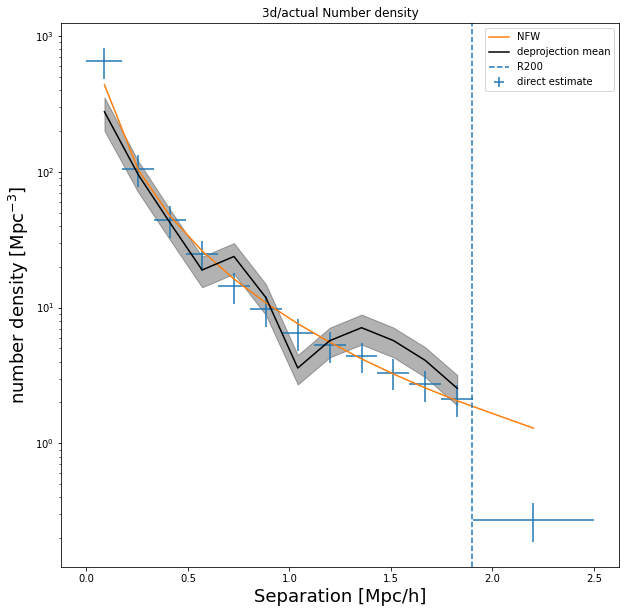

In [49]:
# Modelling the obtained de-projected profile with NFW and Berkert profile

# parameters for NFW profile
rhos = 70.0 # Normalization of the density profile
rs = 0.7   # scale radius rs= r200/c200

# Model profile 'NFW'
prof = profile_nfw.NFWProfile(rhos = rhos, rs = rs)

# Application to the dataset for a given cluster/Halo radius
rho_data = prof.density(R_3D)

# plotting the profile with respect to the NFW and Berkert
plt.figure(0, (10, 10))
plt.title('3d/actual Number density')
#plt.errorbar(r_act, number_density,dR_3D,yerr=number_density * N_3D**-0.5, label='first', marker='o', linestyle="")
plt.errorbar(R_3D, number_density, xerr=dR_3D, ls='', yerr=number_density * N_3D**-0.5, label='direct estimate')
plt.plot(R_3D, 1*rho_data , label = 'NFW');
plt.plot(R_3D, nu_all, label='deprojection mean', c='k')
plt.fill_between(R_3D, y1=nu_all_low, y2=nu_all_up, alpha=0.3, color='k')
plt.xlabel('Separation [Mpc/h]',fontsize=18)
plt.ylabel(r'number density [Mpc$^{-3}$]',fontsize=18)
plt.axvline(x=1.90,linestyle='dashed',label = 'R200')
plt.legend(loc=1, numpoints=1)

plt.yscale('log')
#plt.xscale('log')
#plt.ylim((1e0, 1e2))
#plt.xlim((1e-1, 1e1))

In [50]:
# Peculiar velocities of a members from there spectrosocpic redshift
los_v= (c*(z_halo - z_cl)/(1 + z_cl))
los_v.max(), los_v.min()

(3366.0461, -3704.4814)

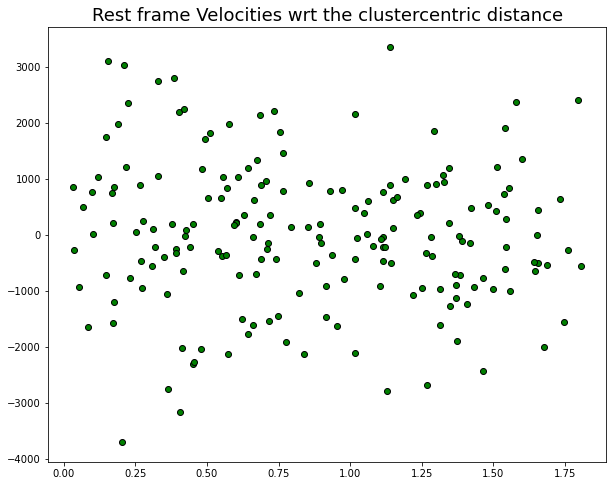

In [51]:
# Peculiar velocities of a members from there spectrosocpic
# redshift and mean redshift of a cluster
plt.figure(figsize=(10,8))

plt.title('Rest frame Velocities wrt the clustercentric distance',fontsize=18)
plt.plot(r_proj,los_v, color='black', linestyle='none', linewidth = 2, marker='.', markerfacecolor='green', markersize=12)


# Getting a profile

In [52]:
# velocity dispersion
# defining the power law to fit the projected velocity dispersion profile
def sigma_v(r,v_0):
    beta=0.1
    return v_0 / (1+ r) ** beta

# biweight estimates of the velocity dispersion for further analysis
def biweight_vdisp(v):

    if v.size > 2:
        sigma = biweight_scale(v, 9)
        return sigma

 # error associated with it
#def biweight_est_error(v):
   # sigma_err = 0.92 * sigma / (np.sqrt(v.size - 1))
   # return sigma_err

# gapper estimate
def gapper_vdisp(v):

    v = np.sort(v)
    n = len(v)
    w = np.arange(1, n) * np.arange(n - 1, 0, -1)
    g = np.diff(v)
    return (np.sqrt(np.pi)) / (n * (n - 1)) * np.sum(w * g)



In [53]:
# function to get the velocity dispersion profile
def velocity_dispersion_profile(r, v, nbins, method="biweight"):

    x= r_proj
    y= los_v

    d, N, mean = [np.zeros(nbins) for i in range(3)]
    bin_width = (max(x) - min(x))/nbins
    left_bin_edges = np.array([min(x) + i*bin_width for i in range(nbins)])
    right_bin_edges = left_bin_edges + bin_width
    mid_bin = left_bin_edges + .5*bin_width

    for i in range(nbins):
        m = (left_bin_edges[i] < x) * (x < right_bin_edges[i])
        mean[i] = np.mean(y[m])
        N[i] = sum(m)
        if method == "std":
            d[i] = np.std(y[m])
        elif method == "mad":
            d[i] = np.sqrt(np.median(y[m]))
        elif method == "rms":
            d[i] = np.sqrt(np.mean((y[m])**2))
        elif method == "biweight":
            d[i] = biweight_vdisp((y[m]))
        elif method == "gapper":
            d[i] = gapper_vdisp((y[m]))

    return mid_bin, d, d/np.sqrt(N), mean


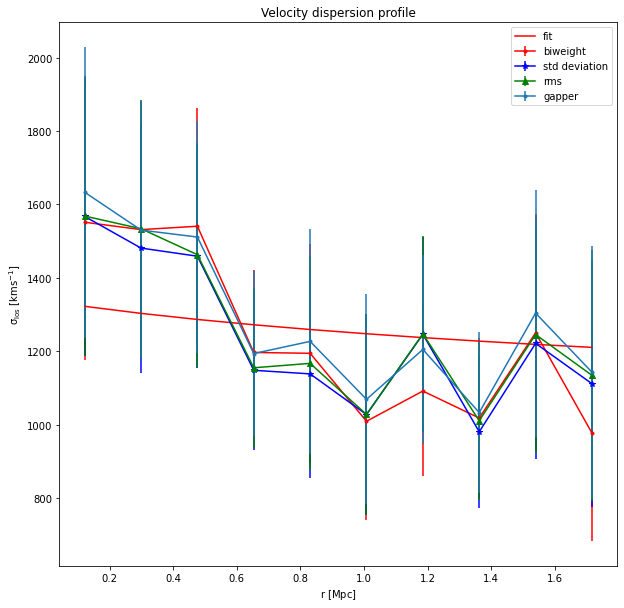

array([1337.49324926])

In [74]:
# getting the profile
nbins=10
bins, dbins, err, mean = velocity_dispersion_profile(r_proj, los_v,nbins, method="biweight")
bins1, dbins1, err1, mean1=velocity_dispersion_profile(r_proj, los_v, nbins, method="std")  # 12 is the best
bins2, dbins2, err2, mean2 =velocity_dispersion_profile(r_proj, los_v, nbins, method="rms")
bins3, dbins3, err3, mean3 =velocity_dispersion_profile(r_proj, los_v, nbins, method="gapper")

#plotting the Velocity dispersion profile
plt.figure(0, (10, 10))
plt.title("Velocity dispersion profile")
plt.errorbar(bins, dbins, yerr=err,color='red', fmt=".",  label="biweight", linestyle='-')
plt.errorbar(bins1, dbins1, yerr=err1,color='blue',fmt="*",  label="std deviation",linestyle='-')
plt.errorbar(bins2, dbins2, yerr=err2,color='green', fmt="^", label="rms",linestyle='-')
plt.errorbar(bins3, dbins3, yerr=err3,fmt=".", label="gapper",linestyle='-')

# fitting using the power law for the line of sight velocity dispersion profile
popt, pcov = curve_fit(sigma_v,bins2,dbins2)

# plotting the function
plt.figure(0, (10, 10))
plt.title("Velocity dispersion profile")
plt.plot(bins, sigma_v(bins, *popt), 'r-',label='fit' )
plt.xlabel("$\mathrm{r~[Mpc]}$")
plt.ylabel("$\mathrm{\sigma_{los}~[kms^{-1}]}$")
#plt.xscale('log')
#plt.yscale('log')
plt.legend()
plt.show()
popt

In [75]:
biweight_vdisp(los_v)

1265.6295314202941

In [76]:
#three different estimation based on the paper @https://articles.adsabs.harvard.edu/pdf/1990AJ....100...32B
# @https://arxiv.org/abs/2006.05949

# biweight estimates of the velocity dispersion
def biweight_vdisp(v):
    
    if v.size > 2:
        sigma = biweight_scale(v, 9)
        return sigma
    
def biweight_est_error(v):
    sigma_err = 0.92 * sigma / (np.sqrt(v.size - 1))
    return sigma_err

def gapper_vdisp(v):
   
    v = np.sort(v)
    n = len(v)
    w = np.arange(1, n) * np.arange(n - 1, 0, -1)
    g = np.diff(v)
    return (np.sqrt(np.pi)) / (n * (n - 1)) * np.sum(w * g)

def sigma_std(v):
    return np.std(v)

def avg_vel(v):
    return np.sqrt(np.average((los_v**2)))
# power law to fit the profile
def sigma_v(r,v_0):
    beta=0.1
    return v_0 / (1+ r) ** beta

array([1229.1912276])

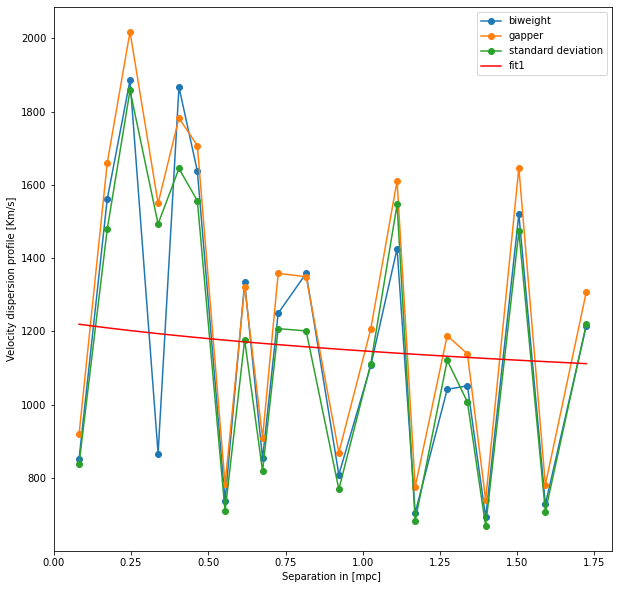

In [77]:
# function define's equally-spaced velocity bins ie the equal number of velocity candidate in all bin's
def velocity_bins(rf_vel, n):
    for i in range(0, len(rf_vel), n):   
        """
        input : rf_vel
        no of candidate per bin : n
        
        output:   equal number of candidate per bin  
        """
        yield rf_vel[i:i + n]
        
num=9
# radial bins      
r_mid=list(velocity_bins(np.sort(r_proj),num))

# mid pt in the each radial bin
rmid_pt=np.array([np.mean(r_mid[i]) for i in range(len(r_mid))])

# similarly velocity bins
los=list(velocity_bins(los_v,num)) 

# dispersion profile using biweight estimator,gapper and standard deviation method
vdisp=np.array([biweight_vdisp(los[i]) for i in range(len(los))]) 

vdisp2=np.array([gapper_vdisp(los[i]) for i in range(len(los))]) 

vdisp3=np.array([np.std(los[i]) for i in range(len(los))]) 

# fitting using the power law for the line of sight velocity dispersion profile
popt, pcov = curve_fit(sigma_v,rmid_pt,vdisp3)

# plotting the function
plt.figure(0, (10, 10))
#plt.plot(rmid_pt, sigma_v(rmid_pt, *popt), 'r-',label='fit' )
plt.plot(rmid_pt,vdisp,'o',linestyle= '-',label = 'biweight')
plt.plot(rmid_pt,vdisp2,'o',linestyle= '-',label = 'gapper')
plt.plot(rmid_pt,vdisp3,'o',linestyle= '-',label = 'standard deviation')
#plt.plot(rmid_pt, sigma_v(rmid_pt, *popt), 'r-',label='fit' )
plt.xlabel('Separation in [mpc] ')
plt.ylabel('Velocity dispersion profile [Km/s]')
plt.plot(rmid_pt, sigma_v(rmid_pt, *popt), 'r',label='fit1' )
plt.legend()

popt


In [78]:
x = r_proj
y = los_v


def running_dispersion(x, y, bsize, mad=False):
    
    assert x[0] == np.sort(x)[0], "arrays must be sorted on x."
    
    # Calculate running std of points in bin of bsize
    d, newx = [], []
    for i in range(len(x)):
        if i+bsize < len(x):
            if not mad:
                d.append(np.std(y[i:i + bsize]))
            else:
                d.append(np.median(np.abs(y[i:i + bsize])))
            newx.append(x[i])
    
    return np.array(newx), np.array(d)

def binned_dispersion(x, y, nbins, method="rms"):
    
    d, N, mean = [np.zeros(nbins) for i in range(3)]
    bin_width = (max(x) - min(x))/nbins
    left_bin_edges = np.array([min(x) + i*bin_width for i in range(nbins)])
    right_bin_edges = left_bin_edges + bin_width
    mid_bin = left_bin_edges + .5*bin_width
    
    for i in range(nbins):
        m = (left_bin_edges[i] < x) * (x < right_bin_edges[i])
        mean[i] = np.mean(y[m])
        N[i] = sum(m)
        if method == "std":
            d[i] = np.std(y[m])
        elif method == "mad":
    #d[i] = np.median(np.abs(y[m]))
            d[i] = np.sqrt(np.median(y[m]))
        elif method == "rms":
            d[i] = np.sqrt(np.mean((y[m])**2))
    return mid_bin, d, d/np.sqrt(N), mean

array([1229.1912276])

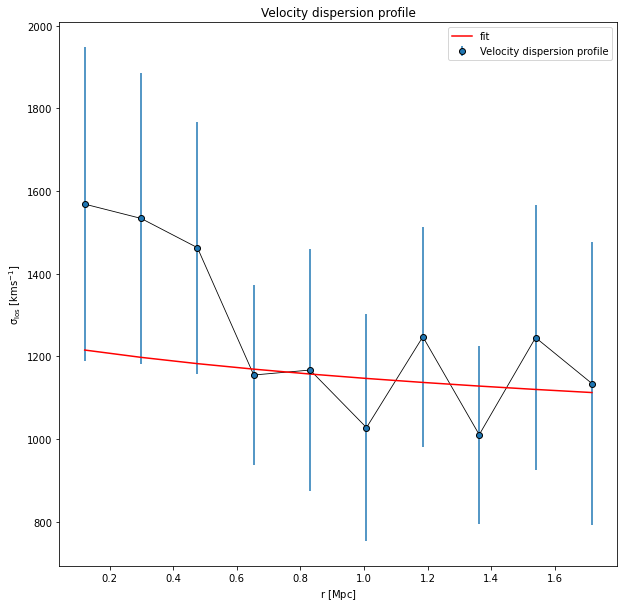

In [79]:
# getting the profile
bins, dbins, err, mean = binned_dispersion(r_proj, los_v, 10, method="rms")
#popt, pcov = curve_fit(sigma_v,bins,dbins)


plt.figure(0, (10, 10))
plt.title("Velocity dispersion profile")
plt.errorbar(bins, dbins, yerr=err, fmt="o", markeredgecolor="k", label="Velocity dispersion profile")
plt.plot(bins, dbins, "k", lw=.8)
plt.plot(bins, sigma_v(bins, *popt), 'r-',label='fit' )
plt.xlabel("$\mathrm{r~[Mpc]}$")
plt.ylabel("$\mathrm{\sigma_{los}~[kms^{-1}]}$")

#plt.xscale('log')
#plt.yscale('log')
plt.legend()
popt

In [80]:
dbins

array([1568.20324707, 1533.62573242, 1462.82531738, 1154.72753906,
       1166.72827148, 1027.51391602, 1247.21691895, 1010.29528809,
       1245.25842285, 1134.11877441])

In [81]:
nvd=n_2D*(np.array(dbins))**2
plt.plot(R_2D,nvd,color='black', linestyle='dashed', linewidth = 2, marker='o', markerfacecolor='green', markersize=12)

ValueError: operands could not be broadcast together with shapes (13,) (10,) 

In [68]:
nvd=n_2D*(np.array(los_vd))**2
# deprojecting the line of sight  velocity dispersion

dndV=np.array(np.gradient(nvd,R_2D))
#n_2D_no0 = N_2D
#n_2D_no0[N_2D==0] = 1

#dndR_up = np.array(np.gradient( n_2D + n_2D * n_2D_no0**-0.5, R_2D ))
#dndR_low = np.array(np.gradient( n_2D - n_2D * n_2D_no0**-0.5, R_2D ))

def get_sigma_all(dndV):
    aa = np.hstack((np.array([0]),np.array(R_2D), np.array([2.4]) ))
    bb = np.hstack((np.array(dndV[0]),np.array(dndV), np.array([0.]) ))

    # getting the interpolation
    interpol1 = interp1d(aa, bb, bounds_error=True)

    # De-projection of the number density profile from 
    # 2D to 3D using the Abel inversion equation

    def sigma(R, r):
        """
        Latex equation
        Reference to the article it comes from
        """
        return (-1/np.pi)*(interpol1(R)/((R**2 - r**2)**0.5))
        #return (-1/(2*np.pi**2))*(inter1(R)/((R**2 - r**2)**0.5))

    
    sigma_all=[integrate.quad(sigma, r_i, 1.90, args=(r_i))[0] for r_i in R_3D]
    return sigma_all

sigma_all = get_sigma_all(dndV)
sigma_r=np.sqrt(np.array(sigma_all)/(np.array(nu_all)))
sigma_r

NameError: name 'los_vd' is not defined

In [ ]:
#finding the slop of the density as well as velocity profile
dln_nu=R_3D /nu_all *(np.gradient(nu_all,R_3D))
dln_sigma=R_3D/sigma_r*(np.gradient(sigma_r,R_3D))
dln_nu,dln_sigma

In [ ]:
const.G

In [ ]:
# Jeans Mass profile
M=(-R_3D.max()*(1265.94317590534**2))/const.G #*(dln_nu +dln_sigma)
M

In [ ]:
#si=np.searchsorted(r_proj.value,r_bins)
#np.split(r_proj.value,si)[1:]
#ri=[len(x) for x in np.split(np.sqrt(np.sort(r_proj)**2),si)[1:]]
#np.split(np.sqrt(los_v**2),si)[1:]

#dd=[np.sum(x)/len(x) for x in np.split(np.sqrt(los_v**2),si)[1:]]
#dd

In [ ]:
len(ra_masked),len(z_halo)

# Caustic Analysis

In [ ]:
cluster_data=np.vstack((ra_masked,dec_masked,z_halo)).T

In [ ]:
import causticpy
caustic= causticpy.Caustic()
caustic.run_caustic(cluster_data)


In [ ]:
from astLib import astCoords as aco
from astLib import astStats as ast
from astLib import astCalc as aca

In [ ]:
# similarly 
r200 = np.sqrt(3) *1211.770939642289 /(10*aca.H0 * aca.Ez(z_cl))
r200

In [ ]:
# m200 and r200 using Saro2013 
#  https://iopscience.iop.org/article/10.1088/0004-637X/772/1/47/pdf  '''  

a = 939
b = 2.91
c = 0.33
m200 = (1211.770939642289**b/(a * ((aca.H0 * aca.Ez(z_cl))/72)**c)**b)
m200 # 1e15


In [ ]:
plt.figure(0, (10, 10))
plt.plot(caustic.r,caustic.v,'o')
plt.plot(r_proj,los_v,'*')

In [ ]:
caustic.r
caustic.v

In [ ]:
plt.plot(caustic.r,caustic.v,color='black', linestyle='none', linewidth = 2, marker='.', markerfacecolor='green', markersize=12)
plt.plot(r_proj,los_v,color='black', linestyle='none', linewidth = 2, marker='+', markerfacecolor='red', markersize=12)

In [ ]:
caustic.run_caustic(cluster_data,clus_ra=caustic.clus_ra,clus_dec=caustic.clus_dec,clus_z=caustic.clus_z)

In [ ]:
caustic.r200_est

In [ ]:
caustic.gal_vdisp,caustic.vdisp_gal,caustic.M200_est/ 1e15

In [ ]:
caustic.run_caustic(cluster_data, r200=caustic.r200, gal_r=caustic.r,
                    gal_v=caustic.v, clus_z=caustic.clus_z,
                    clus_ra=caustic.clus_ra, clus_dec=caustic.clus_dec,
                    rlimit=3, vlimit=2000,
                    clus_vdisp=caustic.vdisp_gal, xmax=3)

In [ ]:
caustic.M200_est/ 1e15

In [ ]:
caustic.ang_d

In [ ]:
caustic.angle
z_cl=caustic.clus_z
caustic.ang_d
caustic.lum_d
caustic.v
caustic.data_set.T # velocities of the galaxies after clipping
caustic.x_range
caustic.y_range
caustic.img_tot
caustic.caustic_profile
caustic.caustic_fit
caustic.gal_vdisp
caustic.memflag


In [ ]:
plt.title('Caustics')
caustic_profile=caustic.caustic_profile
caustic_radii=caustic.x_range
plt.plot(caustic_radii, caustic_profile, color='indigo')
plt.plot(caustic_radii, -1*caustic_profile, color='indigo')  # assumes caustic
plt.xlabel('projected angular separation [Mpc]')
plt.ylabel('line of sight velocities [Km/sec]')
plt.show

In [ ]:
plt.plot(caustic.r,caustic.v,color='red', linestyle='none',marker='+')
plt.plot(caustic_radii, caustic_profile, color='indigo')
plt.plot(caustic_radii, -1*caustic_profile, color='indigo') 

In [ ]:
caustic.clus_dec

In [ ]:
projected_radius=np.array(caustic.r)
peculiar_velocity=np.array(los_v)
cluster_redshift=caustic.clus_z
cluster_RA=caustic.clus_ra
cluster_DEC=caustic.clus_dec

caustic_profile=caustic.caustic_profile

caustic_mask = np.array([x==1 for x in caustic.memflag])
cut_radius = np.transpose(caustic.data_set)[0]
cut_velocity = np.transpose(caustic.data_set)[1]
cut_RA = np.transpose(caustic.data_set)[2]
cut_DEC = np.transpose(caustic.data_set)[3]
cut_z = np.transpose(caustic.data_set)[4]

trimmed_radius = cut_radius[caustic_mask]
trimmed_velocity = cut_velocity[caustic_mask]

In [ ]:
# plot the original and rejected data
plt.figure(figsize=(8,8))
plt.title('Members under caustics')

plt.plot(caustic_radii, caustic_profile, color='indigo')
plt.plot(caustic_radii, -1*caustic_profile, color='indigo')
plt.plot(trimmed_radius,trimmed_velocity,'*',color='blue',)
plt.plot(cut_radius,cut_velocity, '+', color='red', label="original data")
plt.xlabel('projected angular separation [Mpc]')
plt.ylabel('line of sight velocities [Km/sec]')
plt.show


In [ ]:
plt.plot(cut_radius, cut_velocity, '+', color='red')
plt.plot(trimmed_radius, trimmed_velocity, '.')


In [ ]:
len(trimmed_velocity)

In [ ]:
h0=67.77
class MassCalc:
    """
    MassCalc(self,ri,A,vdisp,r200=None,conc1=None,beta=None,fbr=None):

        ri - rgrid values

        A - caustic profile values

        vdisp - galaxy velocity dispersion

        r200 = 2.0 - critical radius of cluster. Default is 2.0, but advised to take the output r200 and rerun
        the analysis with this better estimate.

        conc1 = None - concentration of cluster. If None given then calculated from relationship

        beta = 0.2 - Anisotrpy parameter. Default value is 0.2, but a profile can be given that has same xvalues as ri.

        fbr = None - An exact guess of Fbeta by whatever means. Usually not used.

        H0 = 100.0 - Hubble constant
    """
    
    def __init__(self,ri,A,vdisp,clus_z,r200=None,conc1=None,beta=0.25,fbr=None,H0=h0):
        "Calculate the mass profile"
        G = 6.67E-11
        solmass = 1.98892e30
        self.crit = 2.7745946e11*(H0/100.0)**2.0*(0.25*(1+clus_z)**3.0 + 0.75)
        r2 = ri[ri>=0]
        A2 = A[ri>=0]
        kmMpc = 3.08568025e19
        sumtot = np.zeros(A2.size)
        #print 'Using beta = %.2f'%(beta)
        if conc1 == None:
            #self.conc = 4.0*(vdisp/700.0)**(-0.306)
            self.conc = 5.0 + np.random.normal(0,2.0)
            if self.conc <= 0: self.conc = 5.0
        else:
            self.conc = conc1
        beta = 0.5*(ri/(ri+r200/self.conc))
        self.g_b = (3-2.0*beta)/(1-beta)
        if fbr is None:
            self.f_beta = 0.5*((r2/r200*self.conc)**2)/((1+((r2/r200*self.conc)))**2*np.log(1+((r2/r200*self.conc))))*self.g_b
            self.f_beta[0] = 0
            for i in range(A2.size-1):
                i += 1    
                sumtot[i] = np.trapz(self.f_beta[1:i+1]*(A2[1:i+1]*1000)**2,(r2[1:i+1])*kmMpc*1000)
                #sum[i] = np.trapz((A2[:i+1]*1000)**2,(r2[:i+1])*kmMpc*1000)
            #sum = integrate.cumtrapz(self.f_beta*(A2[:f_beta.size]*1000)**2,r2[:f_beta.size]*kmMpc*1000,initial=0.0)
        else:
            if type(fbr) == float or type(fbr) == int or type(fbr) == np.float64:
                self.f_beta = np.zeros(A2.size)+fbr*1.0
            else:
                self.f_beta = fbr
            self.f_beta[0] = 0
            for i in range(A2.size-1):
                i += 1    
                sumtot[i] = np.trapz(self.f_beta[1:i+1]*(A2[1:i+1]*1000)**2,(r2[1:i+1])*kmMpc*1000)
                #sum[i] = np.trapz((A2[:i+1]*1000)**2,(r2[:i+1])*kmMpc*1000)
            #sum = integrate.cumtrapz(self.f_beta*(A2[:f_beta.size]*1000)**2,r2[:f_beta.size]*kmMpc*1000,initial=0.0)
        self.massprofile = sumtot/(G*solmass)
        
        #return the caustic r200
        self.avg_density = self.massprofile/(4.0/3.0*np.pi*(ri[:self.f_beta.size])**3.0)
        try:
            #self.r200_est = (ri[:self.f_beta.size])[np.where(self.avg_density >= 200*self.crit)[0]+1][-1]
            finterp = interp1d(self.avg_density[::-1],ri[:self.f_beta.size][::-1])
            self.r200_est = finterp(200*self.crit)
            self.r500_est = finterp(500*self.crit)
        except IndexError:
            self.r200_est = 0.0
            self.r500_est = 0.0
        #self.M200_est = self.massprofile[np.where(ri[:self.f_beta.size] <= self.r200_est)[0][-1]]
        finterp = interp1d(ri[:self.f_beta.size],self.massprofile)
        self.M200_est = finterp(self.r200_est)
        self.M500_est = finterp(self.r500_est)
        self.M200 = self.massprofile[np.where(ri[:self.f_beta.size] <= r200)[0][-1]]
        

In [ ]:
m = MassCalc(ri =caustic.x_range,
    A = caustic.caustic_profile,
    vdisp = caustic.vdisp_gal,
    clus_z = caustic.clus_z,
    r200=caustic.r200,
    conc1=5,
    beta=0.33,
    fbr=None,
    H0=67.77,)

In [ ]:
m.g_b

In [ ]:
m.crit,
#m.conc,
(m.massprofile)

In [ ]:
caustic.beta

In [ ]:
m.avg_density

In [ ]:
len(caustic.beta)

In [ ]:
np.mean(caustic.beta)

In [ ]:
plt.plot(trimmed_radius,trimmed_velocity,'+',color='red',)

In [ ]:
# m200 and r200 using Saro2013 
#  https://iopscience.iop.org/article/10.1088/0004-637X/772/1/47/pdf  '''  
a = 939
b = 2.91
c = 0.33
m200 = (caustic.vdisp_gal**b/(a * ((aca.H0 * aca.Ez(z_cl))/72)**c)**b)
r200 = np.sqrt(3) *caustic.vdisp_gal /(10*aca.H0 * aca.Ez(z_cl))
r200,m200

In [ ]:
caustic.gal_vdisp

In [ ]:
caustic.gal_vdisp,caustic.vdisp_gal,caustic.M200_est/ 1e15